In [61]:
import pandas as pd
import importlib

import sys 
import os

os.chdir("../Feature_Design")
from author_properties_transformers import author_influence
from word2vec_transformers import conceptcluster, tokenizer
os.chdir("../Regression")

from datetime import timezone, datetime
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import make_pipeline, make_union
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.preprocessing import FunctionTransformer
import seaborn as sns


# Load and clean data:

In [62]:
df = pd.read_csv("../Data/wsb_full_not_deleted_withdt.csv", nrows = 3000)
df = df.loc[df.author != "None"]
df ["created_datetime_utc"] = df["created_utc"].apply(datetime.utcfromtimestamp)
df['weektime'] = df['created_datetime_utc'].apply( lambda x : x.weekday()*24 + x.hour)
df['time_of_day'] = df['created_datetime_utc'].apply( lambda x : x.hour)

# make tokenized columns for the NLP methods
tokenizer().in_place(X = df, cols = ['title', 'selftext'])

In [63]:

df_cleaned = df[ [  'id', 'tokenized_title', 'author', 'ups', 'weektime', 'time_of_day', 'tokenized_selftext']]

In [64]:
df_cleaned

,id,tokenized_title,author,ups,weektime,time_of_day,tokenized_selftext
0,eipw3g,"[[buy, intu, dd]]",unclerudy,5,71,23,[[httpswwwschaeffersresearchcomcontentanalysis...
1,eipbbd,"[[new, years, challenge, k, makeit, or, breakit]]",DrSecret007,50,71,23,"[[alright, wsbso, i, recently, came, into, abo..."
2,eip6af,"[[how, many, of, you, tisms, are, doing, the, ...",phoq5,27,70,22,"[[i, saw, an, older, thread, on, it, curious, ..."
3,eiop2z,"[[dd, on, pot, stocks]]",Black_Ink,6,70,22,"[[first, day, of, legal, weed, in, illinois, p..."
4,einz9m,"[[markets, are, on, the, cusp, of, a, correcti...",OptionRunners,173,69,21,"[[i, was, going, to, tag, this, as, technical,..."
...,...,...,...,...,...,...,...
2995,f03bjh,"[[anyone, check, on, the, boomers, over, on, s...",GermyBones,35,97,1,"[[futures, dipped, slightly, and, theyre, losi..."
2996,f03aif,"[[ice, recovery]]",Dorikin350Z,10,97,1,"[[i, posted, this, in, the, discussion, but, n..."
2997,f038x3,"[[best, day, to, buy, fridays]]",ifrickinglovedhs,10,97,1,"[[hello, im, fairly, new, to, options, but, i,..."
2998,f038cf,"[[theres, a, chance, of, recession, in, the, n...",SeductiveScrotum,164,97,1,[]


## Create feature transformers for author features, time features, and nlp features.
For details on the author and nlp transformers see, ../Feature_Design/author_properties_transformers and ../Feature_Design/word2vec_transformers

In [65]:
author_stat_features = FeatureUnion([('aggsum', author_influence(kind = 'sum')), 
                           ('aggmean', author_influence(kind = 'mean')), 
                           ('aggmedian', author_influence(kind = 'median')),
                            ('aggcount', author_influence(kind = 'count')),
                              #('aggpowerlaw', author_influence(kind = 'power_law')) # slows things down a lot      
                           
                           ])


In [66]:

time_features = make_union( make_column_transformer(  
                                (FunctionTransformer(lambda x : x), ["weektime", "time_of_day"] ),
                                                   )            
                          )


In [67]:
nlp_features = make_union( conceptcluster(verbose = False) )

In [68]:
# other features -- whether score >= 100
# predictors for whether different kinds of awards were given


In [69]:


all_features = make_union ( author_stat_features, time_features, nlp_features )

## Run a regression experiment:

Trying to predict upvotes using those features. No luck so far. 

Comments: xgboost overfits, linear regression underfits.
 

working on LinearRegression()


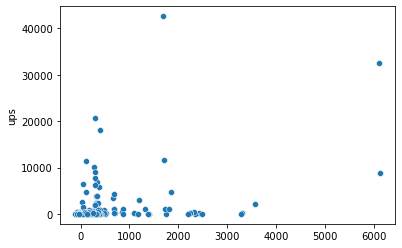

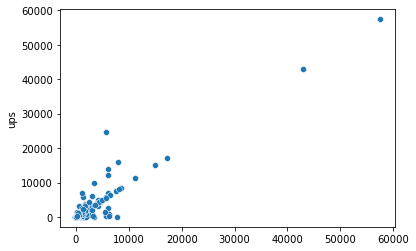

[-0.03548019 -0.09338144  0.10503369 -0.85482962  0.10073596]
working on XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=2, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)


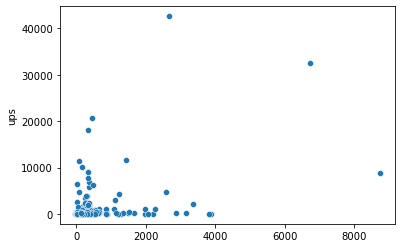

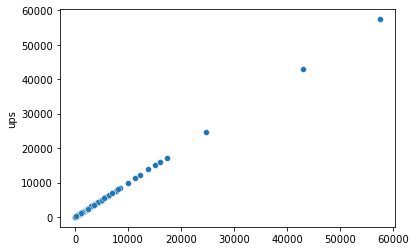

In [ ]:
def run_experiment(model, df):
    
    



    X_train, X_test, y_train, y_test = train_test_split(df, df.ups,
                                                    random_state=0)

    print("working on", model)

    pipe = make_pipeline(all_features, model)
    pipe.fit(X_train, y_train)

    pipe.predict(X_test)

    sns.scatterplot(x = pipe.predict(X_test), y = y_test)
    plt.show()
    sns.scatterplot(x = pipe.predict(X_train), y = y_train)
    plt.show()
    
    scores = cross_val_score(pipe, df, df.ups)
    print(scores)
    
    return pipe

pipes = []
for model in [LinearRegression(), xgb.XGBRegressor(random_state=2)]:
    pipes.append(run_experiment(model, df_cleaned))


In [12]:
# Todo: Do CV to tune hyperparameters.